In [1]:
import csv
import h5py
import numpy as np
import scipy.io
import os

import matplotlib.pyplot as plt

from stability_evaluation import *


# Select The Spike Train to Visualize

This block just select a neuropixel spike train to work with.

In [2]:
nwbf = '/hdd/data/hooshmand/alan/M276039_insertion2_V1_angled3.nwb'
nwf = h5py.File(nwbf, 'r')

# Source of the spike train. One of the following
#    'kilosort'
#    'yass'
#    'goldstandard'
SPT_SOURCE = 'goldstandard'

if SPT_SOURCE == 'kilosort':
    cid = nwf['/processing/V1/Clustering/num'].value
    times = nwf['/processing/V1/Clustering/times'].value
    L_gt = cid[times < 1800]
    spt_gt = times[times < 1800] * 30000
    spike_train = np.concatenate((spt_gt, L_gt))
    spike_train = np.reshape(spike_train, [2, len(L_gt)]).T
    spike_train = spike_train.astype('int32')
    TEMP_TOT = np.max(spike_train[:, 1]) + 1
elif SPT_SOURCE == 'yass':
    f = open('/hdd/data/hooshmand/alan/yass_spt_shenghao.out', 'r')
    spike_train = np.fromfile(f, dtype=int)
    spike_train = np.reshape(spike_train, [len(spike_train)/2, 2])
    f.close()
    TEMP_TOT = np.max(spike_train[:, 1]) + 1
elif SPT_SOURCE == 'goldstandard':
    cid = np.array([])
    times = np.array([])
    i = 1
    for unit in  nwf['/processing/V1/UnitTimes'].keys()[:-1]:
        temp = nwf['/processing/V1/UnitTimes/{}/times'.format(unit)].value
        times = np.append(times, temp)
        cid = np.append(cid, np.repeat(i, len(temp)))
        i += 1
    #L_gt = cid[times < 1800]
    #spt_gt = times[times < 1800] * 30000
    L_gt = cid
    spt_gt = times * 30000
    spike_train = np.concatenate((spt_gt, L_gt))
    spike_train = np.reshape(spike_train, [2, len(L_gt)]).T
    spike_train = spike_train.astype('int32')
    TEMP_TOT = np.max(spike_train[:, 1]) + 1   

# Properties of the unit templates
WINDOW = range(-20, 20)
templates = np.zeros([len(WINDOW), 200, TEMP_TOT])

In [3]:
spike_train

array([[     8240,         1],
       [     8897,         1],
       [    11046,         1],
       ..., 
       [194929070,       127],
       [194929842,       127],
       [194930692,       127]], dtype=int32)

In [4]:
bin_file = '/hdd/data/hooshmand/alan/chunk_30min.dat'
geom_file = '/hdd/data/hooshmand/alan/neuropixel_geometry.txt'

# Find Templates Based on Spike Times

In [5]:
br = RecordingBatchIterator(
    bin_file, geom_file, sample_rate= 30000,
    batch_time_samples = 1000000, n_batches = 5,
    n_chan = 200, radius = 100)
mwc = MeanWaveCalculator(br, spike_train)

  0%|          | 0/5 [00:00<?, ?it/s]

Computing mean waveforms...


100%|██████████| 5/5 [00:59<00:00, 11.92s/it]

Spike time on boundary 3 times.


Let's take a look at some recovered templates.

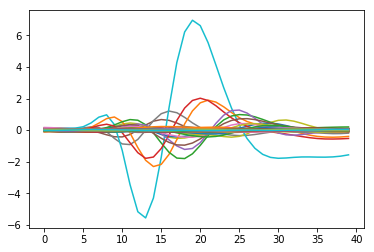

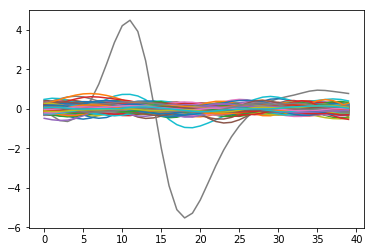

In [6]:
for i in range(2):
    plt.plot(mwc.templates[:, :, i])
    plt.show()

In [16]:
stab = RecordingAugmentation(mwc)

Here we indicate what is the length of the augmented data
in terms of batches (with respect to the batch iterator object.)

In [17]:
# New ground truth spike train.
new_gt_spt = stab.save_augment_recording('dummy_recording.bin', 3)

100%|██████████| 3/3 [00:34<00:00, 11.53s/it]


Let's look at the total number of clusters after augmentation.

In [19]:
max(new_gt_spt[:, 1])

150

## Creating evaluation object for matching, TP, and FP

In [12]:
spt_ = spike_train[spike_train[:, 0] < 1e6, :]
tmp_ = mwc.templates[:, :, np.unique(spt_[:, 1])]
# Let's create a fake new spike train with only 100
# first units of the ground truth as clusters
spt_2 = spt_[spt_[:, 1] < 100, :]
tmp_2 = tmp_[:, :, :100]
# Here we just demonstrate with the sampe spike train
# The second argument should be a different spike train
ev = SpikeSortingEvaluation(spt_, spt_2, tmp_, tmp_2)

100%|██████████| 116/116 [00:06<00:00, 16.59it/s]


In [15]:
print ev.true_positive
print ev.false_positive
print ev.unit_cluster_map

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 1